In [1]:
import os
import sys

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install SmartStockRL package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

    # Clone or update repo.
    repo = "smart-stock-rl"
    repo_url = f"https://github.com/zanderman/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

    # Set dataset root path.
    dataset_root = '~/dataset'

except:
    IN_COLAB = False
    dataset_root = '~/Desktop'
    print('NOT IN COLAB')

# Import package.
import smart_stock as ss

IN COLAB
Already up to date.
Processing ./smart-stock-rl
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for smart-stock: filename=smart_stock-0.0.1-py3-none-any.whl size=22773 sha256=33ccb3f5a02dc4d8dd9ae4b1e54e102a561852003c7fc4d2e2d877171b54d7aa
  Stored in directory: /root/.cache/pip/wheels/5f/9a/51/d85d16e6e8cc024031e89ea4d0070e740e1d0cbc121406bacf
Successfully built smart-stock
  Attempting uninstall: smart-stock
    Found existing installation: smart-stock 0.0.1
    Uninstalling smart-stock-0.0.1:


In [3]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [4]:
# Import other necessary packages after we know that imports are available.
from __future__ import annotations
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

## Dataset

In [5]:
# Request user for Kaggle login if JSON file does not exist.
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.environ.get("KAGGLE_USERNAME",None) is None and os.environ.get("KAGGLE_USERNAME",None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Kaggle Username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:    
        api_key = getpass.getpass(prompt="Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key

    # In Google Colab preserve the login auth across environment restarts.
    if IN_COLAB:
        !mkdir -p ~/.kaggle/
        with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
            json.dump({'username':os.environ["KAGGLE_USERNAME"], 'key':os.environ["KAGGLE_KEY"]}, f)

In [6]:
# Prepare dataset.
stocks = ['aapl', 'nvda', 'dis', 'ko', 'pg']
path = os.path.expanduser(dataset_root)

# This command will download the dataset if it does not exist on the system.
dataset = ss.datasets.HugeStockMarketDataset(path, quiet=False)

## Training Functions

In [7]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

In [8]:
def train(
    agent,
    max_episodes: int = 1000,
    **kwargs,
    ) -> tuple[list[float], bool]:
    """Generic agent training method.

    Specific methods should wrap this one and pass agent-specific arguments
    as keyword arguments.
    """
    # List of reward values for plotting.
    rewards = []

    # Boolean solution flag.
    found_soln = False

    # Episode loop.
    for i in range(max_episodes):
        reward = agent.run_episode(**kwargs)
        rewards.append(reward)
        # if i%100 == 0: print(f'[{i}] {reward}')
        print(f'[{i}] {reward}')

    return rewards, found_soln

In [9]:
def train_QSFM(
    agent: ss.algorithms.qlearning.qsfm.QSFM, 
    max_episodes: int = 1000,
    max_steps: int = None,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train QSFM agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps,
        render=render,
        render_mode=render_mode,
        )

In [10]:
def train_DQN(
    agent: ss.algorithms.deepq.dqn.DQN, 
    max_episodes: int = 1000,
    max_steps: int = None,
    target_update_freq: int = 10,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train DQN agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps, 
        target_update_freq=target_update_freq,
        render=render, 
        render_mode=render_mode,
        )

## Environment

In [11]:
# Create stock environment using specific stock.
df = dataset['aapl']
start_balance = 10000
max_stock = 10 # 1 # 100
start_day = None
env_name = 'StockDataEnv'
env = ss.envs.StockDataEnv(
    df=df, 
    start_balance=start_balance, 
    max_stock=max_stock, 
    start_day=start_day,
)

In [12]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    env.seed(RANDOM_SEED)
    env.action_space.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

In [13]:
# Set tweakable parameters.
gamma = 0.9 # Discount factor (should be in (0,1)).
alpha = 0.01 # 0.0001 # Step size.
epsilon = 0.2 # Epsilon-greedy action selection (should be in (0,1)).

# Initialize linear function approximator by clipping low/high observation range.
order = 3
obs_low = np.clip(env.observation_space.low, -10, 10)
obs_high = np.clip(env.observation_space.high, -10, 10)
lfa = ss.mapping.fourier.FourierStateFeatureMapping(obs_low, obs_high, order)

# Create Q-learning algorithm agent with LFA.
agent = ss.algorithms.qlearning.qsfm.QSFM(env, lfa, gamma, alpha, epsilon)

[0] 4.881516554019229
[1] 4.880595373257537
[2] 4.900231565108777
[3] 4.8781879344802626
[4] 4.872703133765798
[5] 4.680020407194721
[6] 4.869266560228814
[7] 4.874800457987661
[8] 4.686210026989043
[9] 4.903504572245164
[10] 4.621246473306426
[11] 4.886662633130538
[12] 4.650540728975265
[13] 4.890633079034013
[14] 4.884244620323705
[15] 4.515288564960103
[16] 4.891927831456164
[17] 4.952456283715362
[18] 5.0575170481317215
[19] 4.954209135132975
[20] 4.998969305657458
[21] 4.843345761406655
[22] 4.879729014288827
[23] 4.877601295992261
[24] 4.814535232713868
[25] 4.8903926868310394
[26] 4.903183499093452
[27] 4.884324291054793
[28] 5.531280639898706
[29] 4.869142062878872
[30] 4.875701763088964
[31] 4.9127906084893915
[32] 4.876386923371257
[33] 4.886365576931812
[34] 4.876141451256217
[35] 4.7176159576284995
[36] 4.885728981651986
[37] 5.079061029612844
[38] 4.890950075103259
[39] 4.876158457974774
[40] 4.906505179712272
[41] 4.87022461994312
[42] 4.872450326597876
[43] 5.5558839132

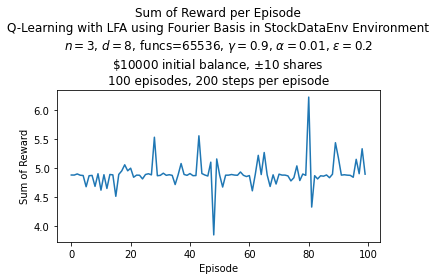

In [14]:
max_episodes = 100 # 1000 # Upper-limit on number of possible episodes.
max_steps = 200
render = False
render_mode = 'csv'

# Train the agent 
with timecontextprint():
    rewards, found_soln = train_QSFM(agent, max_episodes, max_steps, render, render_mode)

# Plot the rewards.
plt.figure()
plt.plot(rewards)
plt.title(f"Sum of Reward per Episode\nQ-Learning with LFA using Fourier Basis in {env_name} Environment\n$n={order}$, $d={obs_low.size}$, funcs={lfa.coeffs.shape[0]}, $\gamma={gamma}$, $\\alpha={alpha}$, $\epsilon={epsilon}$\n\${start_balance} initial balance, $\pm${max_stock} shares\n{max_episodes} episodes, {max_steps} steps per episode")
plt.xlabel('Episode')
plt.ylabel('Sum of Reward')
plt.tight_layout()
plt.show()